# Day 7: Understanding Data Across my Dataset
This notebook explores the intersection of economic growth, inequality, and urban living conditions by combining multiple datasets from international sources.
It's about bringing it all together on the final day of this analysis journey.

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# load the datasets
gdp_metropol = pd.read_excel('../data/gdp_metropol.xls')
gini_disposable = pd.read_excel('../data/gini_disposable_income.xls')
urban_popu = pd.read_excel('../data/urban_living_1.xlsx')
urban_greenspace = pd.read_excel('../data/urban_living_greenspace_2.xlsx')

# only run this with the above cells, other issues present. 
# manage dataset 1
# set row 1 to column names
gdp_metropol.columns = gdp_metropol.iloc[0]
gdp_metropol = gdp_metropol[1:]

# remove last two rows
gdp_metropol = gdp_metropol[:-2]

# manage dataset 2
# set row 1 to column names
gini_disposable.columns = gini_disposable.iloc[0]
gini_disposable = gini_disposable[1:]

# remove last three rows
gini_disposable = gini_disposable[:-3]

# melt data so years are rows not columns 
gini_disposable = gini_disposable.melt(id_vars=["Country", "City/region"], var_name="Year", value_name="Gini")

# convert ".." to proper nulls, then coerce to numeric
gini_disposable = gini_disposable[gini_disposable["Gini"] != ".."]
gini_disposable["Gini"] = pd.to_numeric(gini_disposable["Gini"], errors="coerce")

# manage dataset3
# remove unwanted columns by name
urban_popu = urban_popu.drop(columns=[
    'SDG Goal',
    'SDG Target',
    'SDG Indicator',
    'Country or Territory Name',
    'Data Units',
    'Data Source',
    'Footnote'
])

# manage dataset
# remove unwanted columns by name
urban_greenspace = urban_greenspace.drop(columns=[
    'SDG Goal',
    'SDG Target',
    'SDG Indicator',
    'Country or Territory Code',
    'City Code',
    'Data Units',
    'Data Source',
    'FootNote'
])

# rename long columns
urban_popu = urban_popu.rename(columns={
    'Proportion of urban population living in slums or informal settlements (%) (a)': 'Urban Slum %',
    'Proportion of urban population living in inadequate housing (%) (b)': 'Inadequate Housing %',
    'Country or Territory Name.1': 'Country',
    'Data Reference Year': 'Year',
})

urban_greenspace = urban_greenspace.rename(columns={
    'Average share of the built-up area of cities that is open space for public use for all (%) [a]': 'Open_Space_Share',
    'Average share of urban population with convenient access to open public spaces (%) [b]': 'Urban_Public_Access',
    'Country or Territory Name': 'Country',
    'Data Reference Year': 'Year',
})

In [16]:
w = gdp_metropol
x = gini_disposable
y = urban_popu
z = urban_greenspace

print(w.columns, "\n", x.columns, "\n", y.columns, "\n", z.columns)

Index(['Country', 'Metropolitan areas', 'Value 2017'], dtype='object', name=0) 
 Index(['Country', 'City/region', 'Year', 'Gini'], dtype='object') 
 Index(['Country', 'SDG Region', 'SDG Sub-Region', 'Urban Slum %',
       'Inadequate Housing %', 'Year'],
      dtype='object') 
 Index(['Country', 'SDG Region', 'SDG Sub-Region', 'City Name',
       'Open_Space_Share', 'Urban_Public_Access', 'Year'],
      dtype='object')


# Looking for Common Cities
Now that I have seen all the columns in the datasets, I want to see which have cities that I can work with. 
Then I can create a combined dataset based upon these common cities.

In [26]:
# find all common cities
y.head()
# no cities in y
w.head()
# cities in Metropolitan areas
x.head()
# cities in City/region
z.head()
# cities in City Name

,Country,SDG Region,SDG Sub-Region,City Name,Open_Space_Share,Urban_Public_Access,Year
0,Afghanistan,Central Asia and Southern Asia,Southern Asia,Chārīkār,17.945026,82.053413,2020
1,Afghanistan,Central Asia and Southern Asia,Southern Asia,Farāh,12.133543,62.464343,2020
2,Afghanistan,Central Asia and Southern Asia,Southern Asia,Herat,17.196642,55.557153,2020
3,Afghanistan,Central Asia and Southern Asia,Southern Asia,Jalālābād,15.652377,59.009593,2020
4,Afghanistan,Central Asia and Southern Asia,Southern Asia,Kabul,19.895799,13.043318,2020


In [20]:
# group cities across 3 data frames: w, x, z
# Step 1: Find common cities across all three dataframes
cities_w = set(w['Metropolitan areas'].dropna().unique())
cities_x = set(x['City/region'].dropna().unique()) 
cities_z = set(z['City Name'].dropna().unique())

# Find intersection of all three
common_cities = cities_w & cities_x & cities_z

print(f"Cities in W (GDP): {len(cities_w)}")
print(f"Cities in X (Gini): {len(cities_x)}")
print(f"Cities in Z (Greenspace): {len(cities_z)}")
print(f"Common cities in ALL three: {len(common_cities)}")

if len(common_cities) > 0:
    print("\nCities present in all three datasets:")
    for city in sorted(common_cities):
        print(f"  - {city}")
else:
    print("\nNo exact matches found. Let's check for fuzzy matches...")

Cities in W (GDP): 443
Cities in X (Gini): 223
Cities in Z (Greenspace): 1620
Common cities in ALL three: 33

Cities present in all three datasets:
  - Atlanta
  - Bologna
  - Boston
  - Charlotte
  - Dallas
  - Grenoble
  - Guadalajara
  - Hartford
  - Hidalgo
  - Houston
  - Lille
  - Linz
  - London
  - Lyon
  - Manchester
  - Marseille
  - Memphis
  - Nantes
  - New Orleans
  - Oslo
  - Palermo
  - Paris
  - Portland
  - Porto
  - Providence
  - Seattle
  - Sheffield
  - St. Louis
  - Stockholm
  - Strasbourg
  - Toulon
  - Toulouse
  - Virginia Beach


In [27]:
# Simple join approach - filter each dataset to common cities only
# Filter W to common cities
w_filtered = w[w['Metropolitan areas'].isin(common_cities)].copy()
w_filtered = w_filtered.rename(columns={'Metropolitan areas': 'City', 'Value 2017': 'GDP_Million_USD'})
w_filtered['GDP_Million_USD'] = pd.to_numeric(w_filtered['GDP_Million_USD'], errors='coerce')

# Filter X to common cities  
x_filtered = x[x['City/region'].isin(common_cities)].copy()
x_filtered = x_filtered.rename(columns={'City/region': 'City'})
x_filtered['Year'] = pd.to_numeric(x_filtered['Year'], errors='coerce')
x_filtered['Gini'] = pd.to_numeric(x_filtered['Gini'], errors='coerce')
# Get most recent Gini for each city
x_filtered = x_filtered.sort_values('Year').groupby(['Country', 'City']).last().reset_index()

# Filter Z to common cities
z_filtered = z[z['City Name'].isin(common_cities)].copy()
z_filtered = z_filtered.rename(columns={'City Name': 'City'})
z_filtered['Year'] = pd.to_numeric(z_filtered['Year'], errors='coerce')
z_filtered['Open_Space_Share'] = pd.to_numeric(z_filtered['Open_Space_Share'], errors='coerce')
z_filtered['Urban_Public_Access'] = pd.to_numeric(z_filtered['Urban_Public_Access'], errors='coerce')
# Get most recent data for each city
z_filtered = z_filtered.sort_values('Year').groupby(['Country', 'City']).last().reset_index()

print(f"Filtered datasets:")
print(f"W: {len(w_filtered)} cities")
print(f"X: {len(x_filtered)} cities") 
print(f"Z: {len(z_filtered)} cities")

Filtered datasets:
W: 33 cities
X: 34 cities
Z: 33 cities


In [28]:
# Simple merge - start with GDP data and join the others
combined = w_filtered[['Country', 'City', 'GDP_Million_USD']].copy()

# Join Gini data
combined = combined.merge(
    x_filtered[['Country', 'City', 'Gini', 'Year']], 
    on=['Country', 'City'], 
    how='inner'
)

# Join Greenspace data
combined = combined.merge(
    z_filtered[['Country', 'City', 'Open_Space_Share', 'Urban_Public_Access', 'Year']], 
    on=['Country', 'City'], 
    how='inner',
    suffixes=('_gini', '_green')
)

print(f"Final combined dataset: {len(combined)} cities")
print(f"Countries: {combined['Country'].nunique()}")
print("\nColumns:", combined.columns.tolist())

Final combined dataset: 15 cities
Countries: 6

Columns: ['Country', 'City', 'GDP_Million_USD', 'Gini', 'Year_gini', 'Open_Space_Share', 'Urban_Public_Access', 'Year_green']


### City Finale.
Although there were 33 common cities, only 15 of them existed in all three datasets.

In [ ]:
# Verify the join worked
print("=== VERIFICATION ===")
print(f"Expected cities: {len(common_cities)}")
print(f"Actual cities in combined dataset: {len(combined)}")
print(f"Match: {len(combined) == len(common_cities)}")

print("\n=== SAMPLE DATA ===")
display(combined[['Country', 'City', 'GDP_Million_USD', 'Gini', 'Open_Space_Share', 'Urban_Public_Access']])

print("\n=== DATA COMPLETENESS ===")
for col in ['GDP_Million_USD', 'Gini', 'Open_Space_Share', 'Urban_Public_Access']:
    complete = combined[col].notna().sum()
    print(f"{col}: {complete}/{len(combined)} complete")

=== VERIFICATION ===
Expected cities: 33
Actual cities in combined dataset: 15
Match: False

=== SAMPLE DATA ===


,Country,City,GDP_Million_USD,Gini,Open_Space_Share,Urban_Public_Access
0,France,Paris,891730,0.330,16.104851,51.584052
1,France,Lyon,111077,0.280,18.077185,66.509812
2,France,Toulouse,67315,0.270,15.955533,47.208559
3,France,Strasbourg,32851,0.270,16.901164,73.236906
4,France,Nantes,42217,0.240,17.472397,67.566211
5,France,Lille,53623,0.280,17.749377,67.009249
6,France,Grenoble,26525,0.270,23.222263,75.516607
7,France,Toulon,16173,0.260,13.382624,60.015093
8,France,Marseille,52814,0.290,15.974942,46.495561
9,Italy,Palermo,25111,0.300,16.194851,42.241680



=== DATA COMPLETENESS ===
GDP_Million_USD: 15/15 complete
Gini: 15/15 complete
Open_Space_Share: 14/15 complete
Urban_Public_Access: 15/15 complete


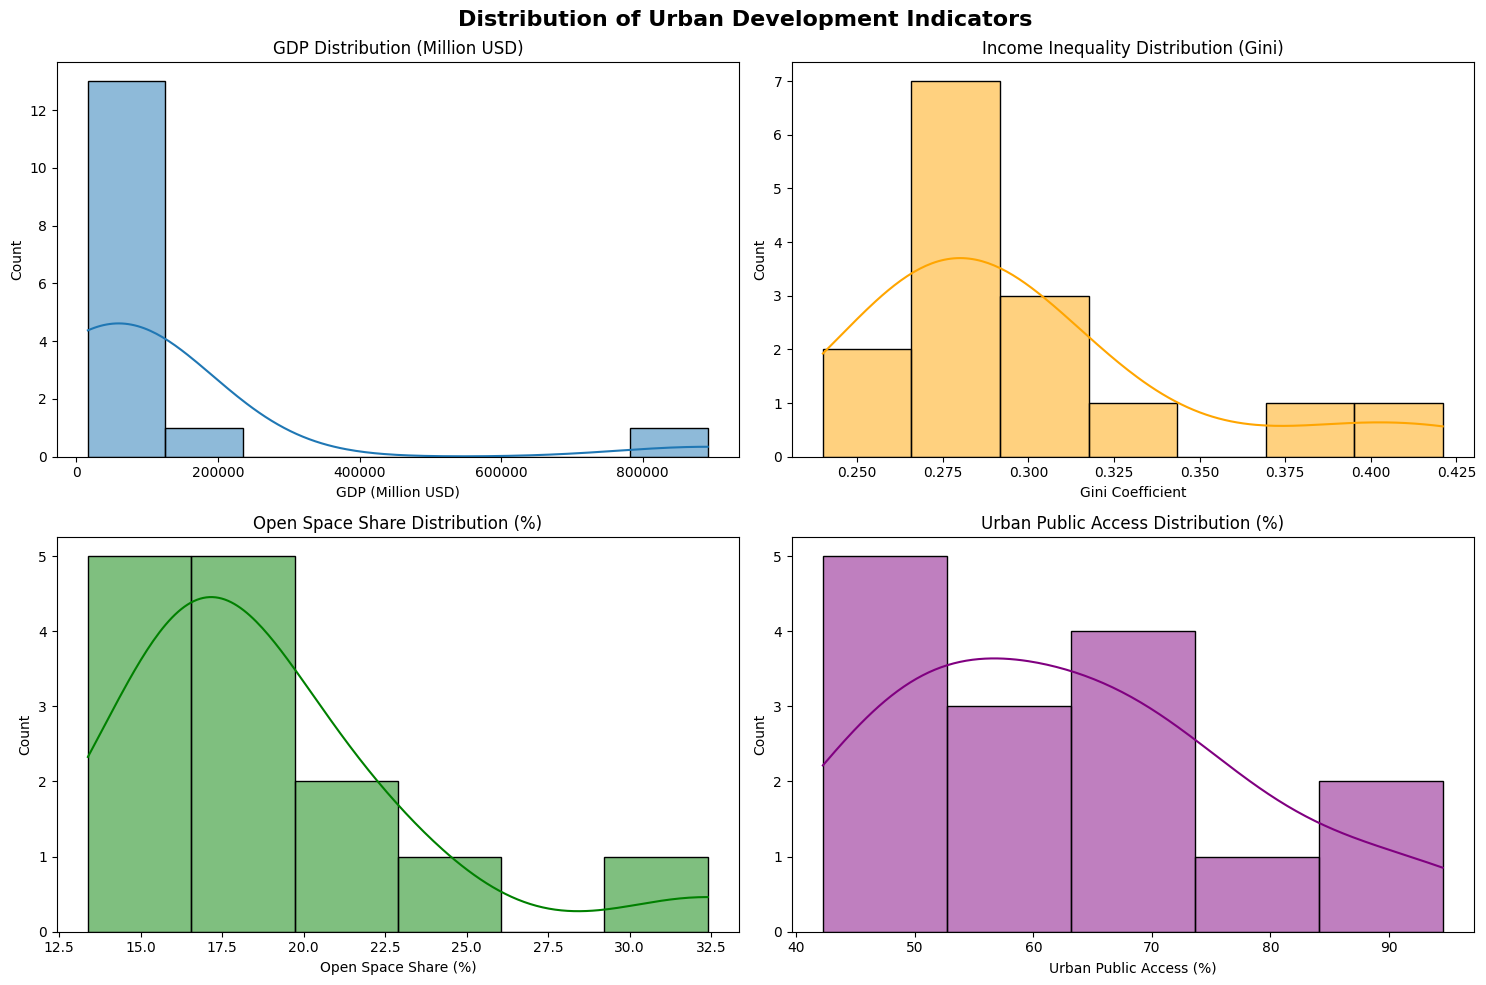

In [31]:
# 1. Distribution plots for each variable
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Distribution of Urban Development Indicators', fontsize=16, fontweight='bold')

# GDP Distribution
sns.histplot(data=combined, x='GDP_Million_USD', kde=True, ax=axes[0,0])
axes[0,0].set_title('GDP Distribution (Million USD)')
axes[0,0].set_xlabel('GDP (Million USD)')

# Gini Distribution
sns.histplot(data=combined, x='Gini', kde=True, ax=axes[0,1], color='orange')
axes[0,1].set_title('Income Inequality Distribution (Gini)')
axes[0,1].set_xlabel('Gini Coefficient')

# Open Space Share Distribution
sns.histplot(data=combined, x='Open_Space_Share', kde=True, ax=axes[1,0], color='green')
axes[1,0].set_title('Open Space Share Distribution (%)')
axes[1,0].set_xlabel('Open Space Share (%)')

# Urban Public Access Distribution
sns.histplot(data=combined, x='Urban_Public_Access', kde=True, ax=axes[1,1], color='purple')
axes[1,1].set_title('Urban Public Access Distribution (%)')
axes[1,1].set_xlabel('Urban Public Access (%)')

plt.tight_layout()
plt.show()

## Distributions of Key Variables
Looking at the distributions of key variables in the combined dataset to understand their characteristics.
For example, the avereage Gini Coefficient is actually quite low, sitting below 0.3.
We can also a lower end of GDP per cities, but with one major player. It will become obvious which one when we plot it.

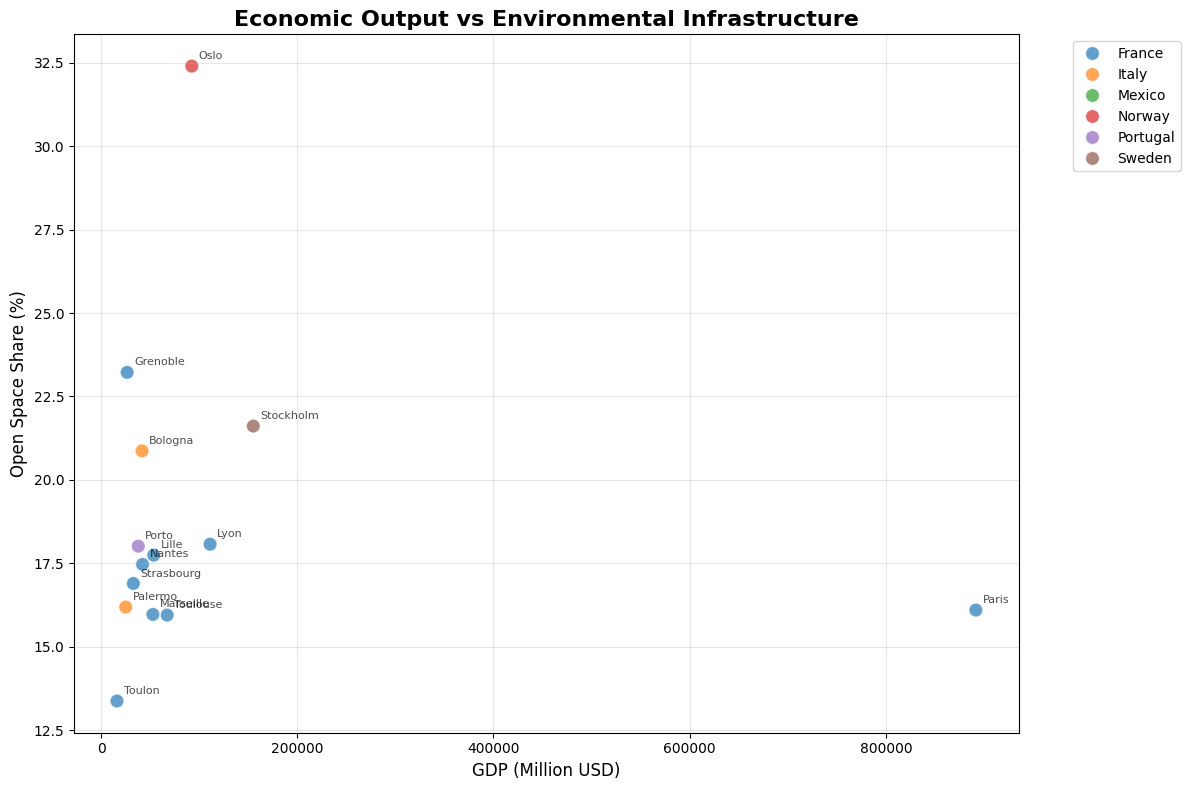

Correlation between GDP and Open Space Share: -0.100
(Values close to 0 indicate little linear relationship)


In [34]:
# 2. Scatter plot: GDP vs Open Space Share
plt.figure(figsize=(12, 8))
sns.scatterplot(data=combined, 
                x='GDP_Million_USD', 
                y='Open_Space_Share',
                hue='Country',
                s=100,
                alpha=0.7)

plt.title('Economic Output vs Environmental Infrastructure', fontsize=16, fontweight='bold')
plt.xlabel('GDP (Million USD)', fontsize=12)
plt.ylabel('Open Space Share (%)', fontsize=12)

# Add city labels for interesting points
for i, row in combined.iterrows():
    plt.annotate(row['City'], 
                (row['GDP_Million_USD'], row['Open_Space_Share']),
                xytext=(5, 5), 
                textcoords='offset points',
                fontsize=8,
                alpha=0.7)

plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Quick correlation check
correlation = combined['GDP_Million_USD'].corr(combined['Open_Space_Share'])
print(f"Correlation between GDP and Open Space Share: {correlation:.3f}")
print("(Values close to 0 indicate little linear relationship)")

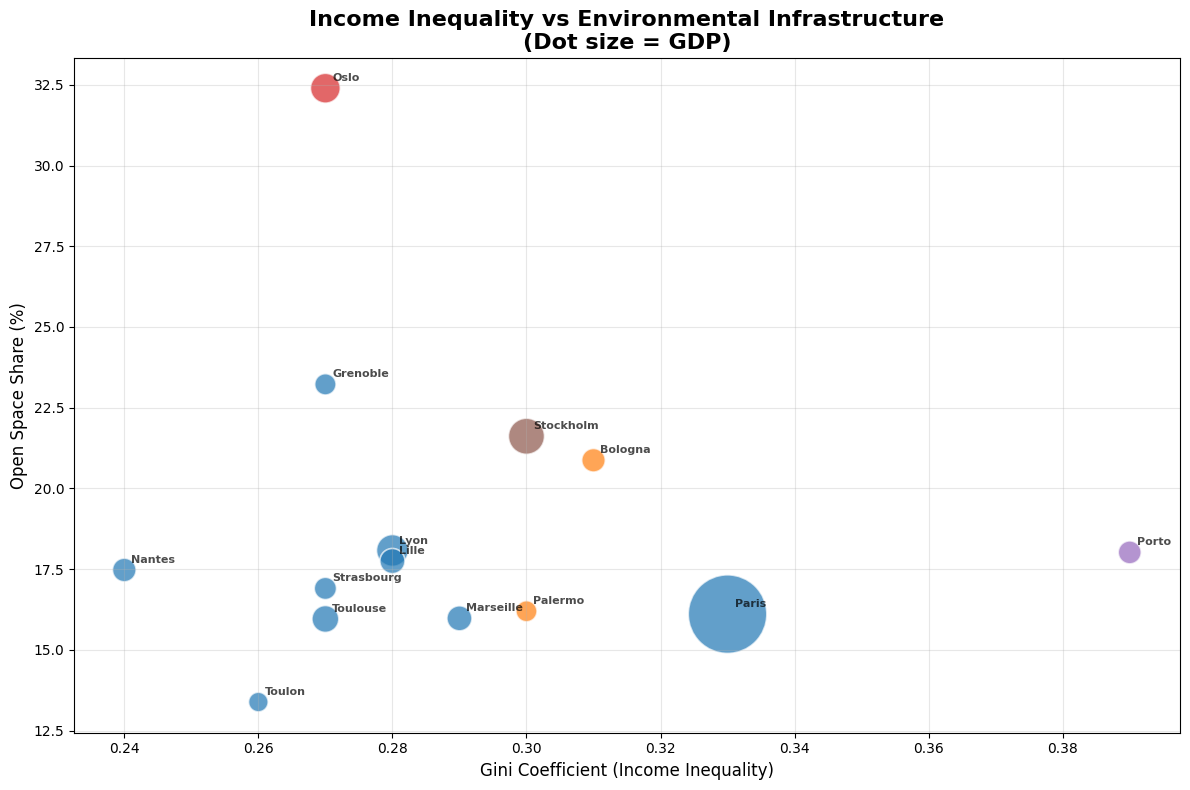

Correlation between Gini and Open Space: -0.073
Correlation between GDP and Gini: 0.213
Correlation between GDP and Open Space: -0.100


In [42]:
# 3. Scatter plot: Gini vs Open Space with GDP as dot size (BIGGER IMPACT)
plt.figure(figsize=(12, 8))
sns.scatterplot(data=combined, 
                x='Gini', 
                y='Open_Space_Share',
                size='GDP_Million_USD',
                hue='Country',
                sizes=(200, 3200),  # Doubled from (100, 800) for even bigger impact!
                alpha=0.7)

plt.title('Income Inequality vs Environmental Infrastructure\n(Dot size = GDP)', fontsize=16, fontweight='bold')
plt.xlabel('Gini Coefficient (Income Inequality)', fontsize=12)
plt.ylabel('Open Space Share (%)', fontsize=12)

# Add city labels for interesting points
for i, row in combined.iterrows():
    plt.annotate(row['City'], 
                (row['Gini'], row['Open_Space_Share']),
                xytext=(5, 5), 
                textcoords='offset points',
                fontsize=8,
                fontweight='bold',
                alpha=0.7)

plt.grid(True, alpha=0.3)

# Remove BOTH size and country legends for cleaner look
plt.gca().get_legend().remove()

plt.tight_layout()
plt.show()

# Quick correlation checks
corr_gini_space = combined['Gini'].corr(combined['Open_Space_Share'])
corr_gdp_gini = combined['GDP_Million_USD'].corr(combined['Gini'])
corr_gdp_space = combined['GDP_Million_USD'].corr(combined['Open_Space_Share'])

print(f"Correlation between Gini and Open Space: {corr_gini_space:.3f}")
print(f"Correlation between GDP and Gini: {corr_gdp_gini:.3f}")
print(f"Correlation between GDP and Open Space: {corr_gdp_space:.3f}")

## Income Inequality vs Environmental Infrastructure

This scatterplot compares income inequality (x-axis, Gini coefficient) with environmental infrastructure (y-axis, open space share) across selected cities, with bubble size representing GDP. A few trends emerge:

- Oslo stands out as a high performer, combining low inequality with abundant open space.

- Paris illustrates the opposite: a wealthy city (large GDP bubble) but with relatively high inequality and below-average greenspace.

- Southern European cities such as Palermo and Bologna cluster around moderate inequality with middling environmental provision.

- French cities (Nantes, Lyon, Marseille, etc.) form a consistent band of low inequality but also relatively modest greenspace.

Overall, the figure underscores that higher GDP does not automatically guarantee equitable or sustainable urban environments.

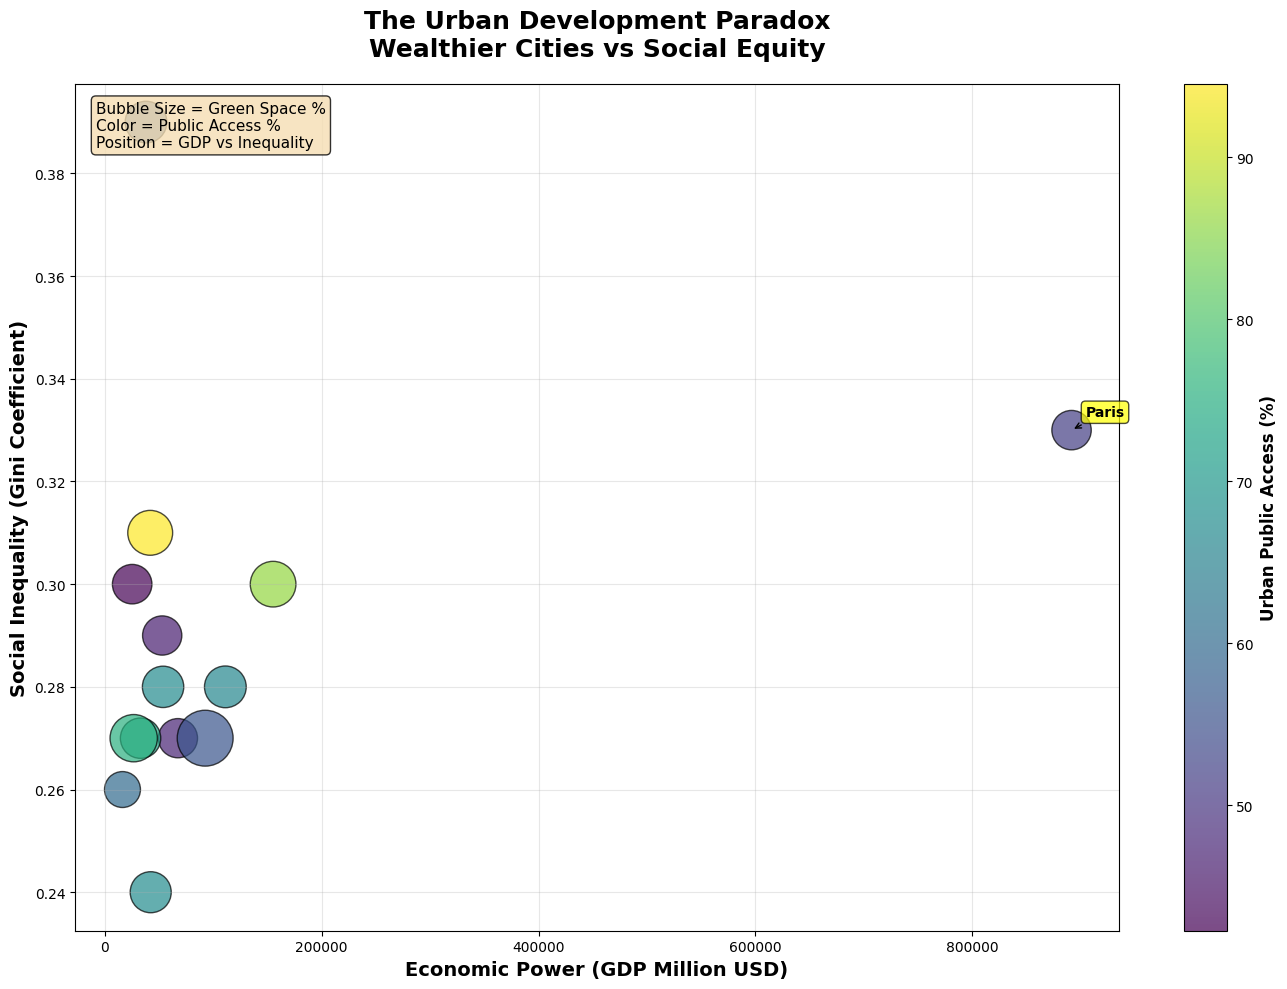

🏙️  THE URBAN DEVELOPMENT PARADOX 🏙️
💰 Richest city: Paris
⚖️  Most unequal: Guadalajara
🌳 Greenest: Oslo
🚶 Best access: Bologna

💡 The bigger the bubble, the greener the city!
💡 Yellow = better public access, Purple = worse access


In [44]:
# Final graph: Dynamic bubble story - The Urban Development Paradox
plt.figure(figsize=(14, 10))

# Create bubble chart with multiple dimensions
scatter = plt.scatter(combined['GDP_Million_USD'], 
                     combined['Gini'], 
                     s=combined['Open_Space_Share']*50,  # Bubble size = green space
                     c=combined['Urban_Public_Access'],   # Color = public access
                     alpha=0.7,
                     cmap='viridis',
                     edgecolors='black',
                     linewidth=1)

# Add colorbar for public access
cbar = plt.colorbar(scatter)
cbar.set_label('Urban Public Access (%)', fontsize=12, fontweight='bold')

# Style the plot
plt.title('The Urban Development Paradox\nWealthier Cities vs Social Equity', 
          fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Economic Power (GDP Million USD)', fontsize=14, fontweight='bold')
plt.ylabel('Social Inequality (Gini Coefficient)', fontsize=14, fontweight='bold')

# Add annotations for the most interesting cities
for i, row in combined.iterrows():
    # Only label extreme cases
    if (row['GDP_Million_USD'] > 400000 or 
        row['Gini'] > 0.45 or 
        row['Open_Space_Share'] > 35):
        plt.annotate(row['City'], 
                    (row['GDP_Million_USD'], row['Gini']),
                    xytext=(10, 10), 
                    textcoords='offset points',
                    fontsize=10,
                    fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', 
                             facecolor='yellow', 
                             alpha=0.7),
                    arrowprops=dict(arrowstyle='->', 
                                  connectionstyle='arc3,rad=0'))

# Add grid and style
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Add a text box with the legend explanation
textstr = '''Bubble Size = Green Space %
Color = Public Access %
Position = GDP vs Inequality'''

props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=11,
         verticalalignment='top', bbox=props)

plt.show()

# Tell the story
print("🏙️  THE URBAN DEVELOPMENT PARADOX 🏙️")
print("=" * 50)
print(f"💰 Richest city: {combined.loc[combined['GDP_Million_USD'].idxmax(), 'City']}")
print(f"⚖️  Most unequal: {combined.loc[combined['Gini'].idxmax(), 'City']}")
print(f"🌳 Greenest: {combined.loc[combined['Open_Space_Share'].idxmax(), 'City']}")
print(f"🚶 Best access: {combined.loc[combined['Urban_Public_Access'].idxmax(), 'City']}")
print("\n💡 The bigger the bubble, the greener the city!")
print("💡 Yellow = better public access, Purple = worse access")

## The Urban Development Paradox

This bubble chart reframes the question by plotting GDP vs inequality, with bubble size showing green space provision and colour reflecting public access. The paradox becomes clear:

- Wealthier cities, such as Paris, do not necessarily achieve stronger social equity, despite economic capacity.

- Many mid-sized cities combine moderate GDP with stronger performance on greenspace or accessibility, suggesting that scale is not always an advantage.

- The colour gradient shows variation in how effectively cities translate green space into accessible space, highlighting a second layer of inequality in urban infrastructure.
Together, the plot demonstrates the urban development paradox: prosperity can coexist with persistent inequality unless deliberate policies ensure both equitable distribution and accessibility of environmental assets.